In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from wordcloud import WordCloud
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import VotingClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import nltk
# Download NLTK resources (uncomment if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# File paths
train_file = r'C:\Users\admin\OneDrive\Desktop\capstone-2\train_data.csv'
test_file = r'C:\Users\admin\OneDrive\Desktop\capstone-2\test_data.csv'
hidden_test_file = r'C:\Users\admin\OneDrive\Desktop\capstone-2\test_data_hidden.csv'

In [3]:
# Load datasets
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
hidden_test_data = pd.read_csv(hidden_test_file)

# Data cleaning and preprocessing

In [4]:
train_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive


In [5]:
train_data.shape

(4000, 8)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  4000 non-null   object
 1   Product Brand        4000 non-null   object
 2   categories           4000 non-null   object
 3   primaryCategories    4000 non-null   object
 4   reviews.date         4000 non-null   object
 5   reviews.text         4000 non-null   object
 6   reviews.title        3990 non-null   object
 7   sentiment            4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB


In [7]:
train_data.isnull().sum()

Name of the product     0
Product Brand           0
categories              0
primaryCategories       0
reviews.date            0
reviews.text            0
reviews.title          10
sentiment               0
dtype: int64

In [8]:
# Impute missing values in 'reviews.title' with the mode
mode_title = train_data['reviews.title'].mode()[0]
train_data['reviews.title'].fillna(mode_title, inplace=True)

In [9]:
train_data.describe()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,4000,4000,4000,4000,4000,4000,4000,4000
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,676,4000,628,2600,99,4,110,3749


In [10]:
train_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')

In [41]:
test_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,reviews.text_cleaned,reviews.title_cleaned,processed_text
0,19,Amazon,11,0,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,amazon kindle fire free used that want online ...,very handy device,amazon kindl fire lot free app use one want ge...
1,9,Amazon,6,1,2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,echo show great addition amazon family work ju...,another winner from amazon,echo show great addit amazon famili work like ...


In [43]:
hidden_test_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews.text_cleaned,reviews.title_cleaned,processed_text
0,19,Amazon,11,0,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive,amazon kindle fire free used that want online ...,very handy device,amazon kindl fire lot free app use one want ge...
1,9,Amazon,6,1,2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive,echo show great addition amazon family work ju...,another winner from amazon,echo show great addit amazon famili work like ...


In [47]:
# Combine unique values from train and test_data for encoding
name = list(set(train_data['Name of the product']) | set(test_data['Name of the product']))
categories = list(set(train_data['categories']) | set(test_data['categories']))
primaryCategories = list(train_data['primaryCategories'].unique())

# Initialize LabelEncoders
le_name = LabelEncoder()
le_cat = LabelEncoder()
le_pri = LabelEncoder()

# Fit and transform labels
le_name.fit(name)
le_cat.fit(categories)
le_pri.fit(primaryCategories)

# Transform columns in train_data
train_data['Name of the product'] = le_name.transform(train_data['Name of the product'])
train_data['categories'] = le_cat.transform(train_data['categories'])
train_data['primaryCategories'] = le_pri.transform(train_data['primaryCategories'])

# Transform columns in test_data
test_data['Name of the product'] = le_name.transform(test_data['Name of the product'])
test_data['categories'] = le_cat.transform(test_data['categories'])
test_data['primaryCategories'] = le_pri.transform(test_data['primaryCategories'])

# Transform columns in test (assuming similar structure to test_val)
hidden_test_data['Name of the product'] = le_name.transform(hidden_test_data['Name of the product'])
hidden_test_data['categories'] = le_cat.transform(hidden_test_data['categories'])
hidden_test_data['primaryCategories'] = le_pri.transform(hidden_test_data['primaryCategories'])

In [48]:
# Fill missing values in 'reviews.title' column
train_data['reviews.title'].fillna(value=' ', inplace=True)
test_data['reviews.title'].fillna(value=' ', inplace=True)
hidden_test_data['reviews.title'].fillna(value=' ', inplace=True)

In [49]:
# Print the preprocessed 'reviews.text' and 'reviews.title'
print("Preprocessed 'reviews.text':")
train_data['reviews.text'].head()

Preprocessed 'reviews.text':


0    Purchased on Black FridayPros - Great Price (e...
1    I purchased two Amazon in Echo Plus and two do...
2    Just an average Alexa option. Does show a few ...
3    very good product. Exactly what I wanted, and ...
4    This is the 3rd one I've purchased. I've bough...
Name: reviews.text, dtype: object

In [50]:
print("\nPreprocessed 'reviews.title':")
train_data['reviews.title'].head()


Preprocessed 'reviews.title':


0             Powerful tablet
1    Amazon Echo Plus AWESOME
2                     Average
3                 Greattttttt
4               Very durable!
Name: reviews.title, dtype: object

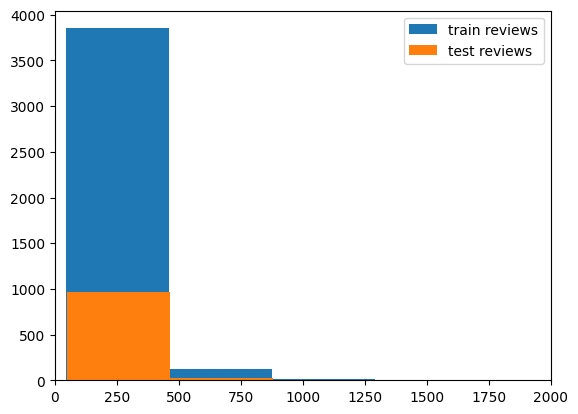

In [51]:
train_len=train_data["reviews.text"].str.len()
test_len=test_data["reviews.text"].str.len()
plt.hist(train_len,bins=20,label="train reviews")
plt.hist(test_len,bins=20,label="test reviews")
plt.legend()
plt.xlim(0,2000)
plt.show()

In [52]:
# Handling categorical variables (example: Label encoding for 'Product Brand')
label_encoder = LabelEncoder()
train_data['Product Brand'] = label_encoder.fit_transform(train_data['Product Brand'])
label_encoder

LabelEncoder()

In [53]:
train_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews.text_cleaned,reviews.title_cleaned,processed_text
0,2,0,10,0,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,purchased black fridaypros great price even sa...,powerful tablet,purchas black fridaypro great price even salev...
1,5,0,1,1,2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,purchased amazon echo plus dot plus four fire ...,amazon echo plus awesome,purchas two amazon echo plu two dot plu four f...


In [44]:
# Displaying processed data (optional)
train_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment', 'reviews.text_cleaned', 'reviews.title_cleaned',
       'processed_text'],
      dtype='object')

In [45]:
test_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'reviews.text_cleaned', 'reviews.title_cleaned', 'processed_text'],
      dtype='object')

In [46]:
hidden_test_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment', 'reviews.text_cleaned', 'reviews.title_cleaned',
       'processed_text'],
      dtype='object')

### Normalize text data

In [35]:
from contractions import contractions_dict

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to expand contractions
def expand_contractions(text, contractions_dict=contractions_dict):
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    return pattern.sub(lambda x: contractions_dict[x.group()], text)

# Sample DataFrame structure
data = {
    'reviews.text': ["I love this product! It's amazing.", "This product is not good. Very bad quality."],
    'reviews.title': ["Great product", "Bad quality"],
    'sentiment': [1, 0]
}

df = pd.DataFrame(data)

# Function for text normalization
def normalize_text(text):
    text = expand_contractions(text)  # Expand contractions
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.strip()  # Remove leading/trailing whitespace
    return text

# Function for tokenization and stemming
def tokenize_and_stem(text):
    tokens = word_tokenize(text)  # Tokenization
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]  # Stemming
    return ' '.join(tokens)

# Function for tokenization and lemmatization
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]  # Lemmatization
    return ' '.join(tokens)

# Apply normalization
df['reviews.text_cleaned'] = df['reviews.text'].apply(normalize_text)
df['reviews.title_cleaned'] = df['reviews.title'].apply(normalize_text)

# Apply tokenization and stemming/lemmatization
df['reviews.text_stemmed'] = df['reviews.text_cleaned'].apply(tokenize_and_stem)
df['reviews.text_lemmatized'] = df['reviews.text_cleaned'].apply(tokenize_and_lemmatize)
df['reviews.title_stemmed'] = df['reviews.title_cleaned'].apply(tokenize_and_stem)
df['reviews.title_lemmatized'] = df['reviews.title_cleaned'].apply(tokenize_and_lemmatize)

df.head()

,reviews.text,reviews.title,sentiment,reviews.text_cleaned,reviews.title_cleaned,reviews.text_stemmed,reviews.text_lemmatized,reviews.title_stemmed,reviews.title_lemmatized
0,I love this product! It's amazing.,Great product,1,i love this product its amazing,great product,love product amaz,love product amazing,great product,great product
1,This product is not good. Very bad quality.,Bad quality,0,this product is not good very bad quality,bad quality,product good bad qualiti,product good bad quality,bad qualiti,bad quality


# Exploratory Data Analysis (EDA):

In [ ]:
# Summary statistics
print("Summary Statistics:")
train_data.describe()


Summary Statistics:


,reviews.text,reviews.title,sentiment,reviews.text_cleaned,reviews.title_cleaned
count,3,3,3,3,3
unique,3,3,2,3,3
top,This is a test review.,Test review,Positive,this test review,test review
freq,1,1,2,1,1


In [ ]:
# Count unique values
print("\nUnique Values in 'sentiment' column:")
train_data['sentiment'].value_counts()


Unique Values in 'sentiment' column:


Positive    2
Negative    1
Name: sentiment, dtype: int64

C:\Users\admin\AppData\Local\Temp\ipykernel_6160\2624921216.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis', hue=None)


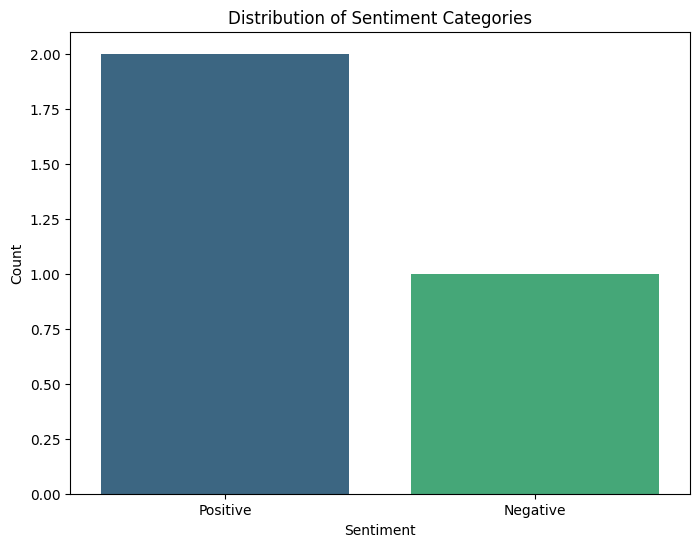

In [ ]:
# Count the number of instances in each sentiment category
sentiment_counts = train_data['sentiment'].value_counts()

# Plot the distribution of sentiment categories
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis', hue=None)
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
# Calculate the percentage of each sentiment category
sentiment_percentage = sentiment_counts / sentiment_counts.sum() * 100
print(sentiment_percentage)

Positive    66.666667
Negative    33.333333
Name: sentiment, dtype: float64


C:\Users\admin\AppData\Local\Temp\ipykernel_6160\3223477082.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_percentage.index, y=sentiment_percentage.values, palette='viridis')


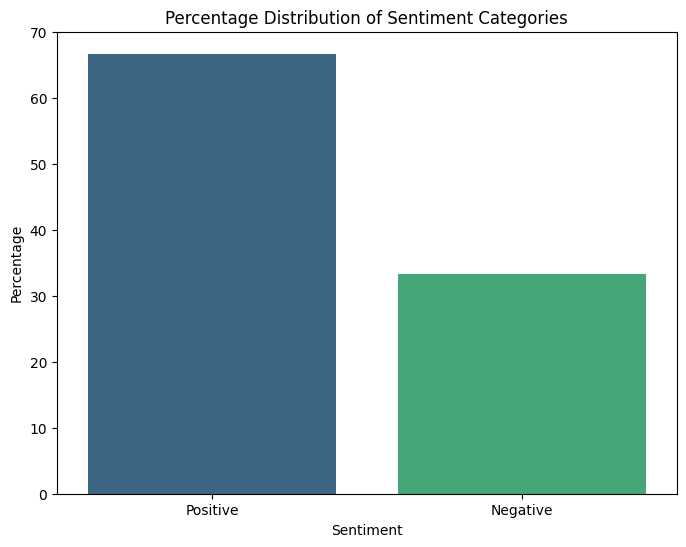

In [ ]:
# Plot the class imbalance
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_percentage.index, y=sentiment_percentage.values, palette='viridis')
plt.title('Percentage Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.show()

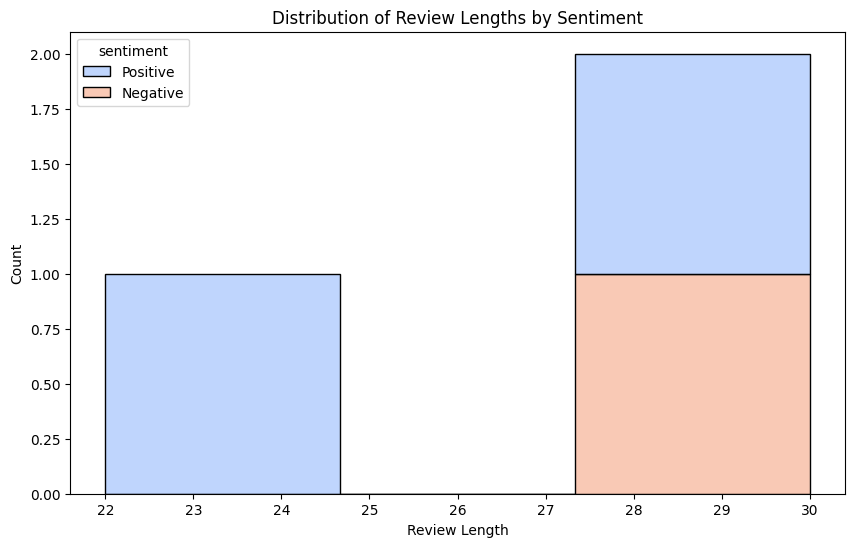

In [ ]:
# Adding a column for review length
train_data['review_length'] = train_data['reviews.text'].apply(len)

# Plot the distribution of review lengths for each sentiment category
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='review_length', hue='sentiment', multiple='stack', palette='coolwarm')
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

In [ ]:
train_data.columns

Index(['reviews.text', 'reviews.title', 'sentiment', 'reviews.text_cleaned',
       'reviews.title_cleaned', 'review_length'],
      dtype='object')

In [ ]:
#all_text = ' '.join([text for text in train['reviews.text']])
pos_text = ' '.join([text for text in train_data['reviews.text'][train_data['sentiment']=='Positive']])
neg_text = ' '.join([text for text in train_data['reviews.text'][train_data['sentiment']=='Negative']])
neu_text = ' '.join([text for text in train_data['reviews.text'][train_data['sentiment']=='Neutral']])

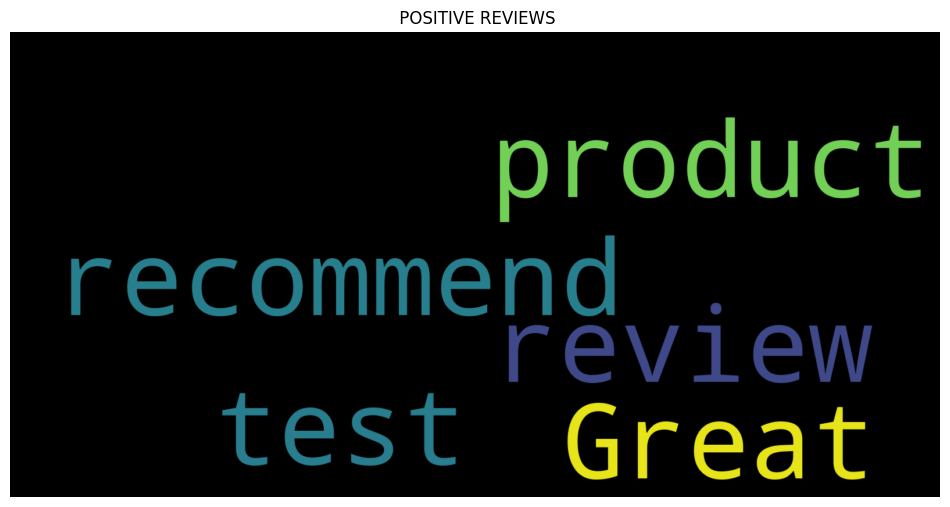

In [ ]:
wordcloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=180).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(' POSITIVE REVIEWS')
plt.show()

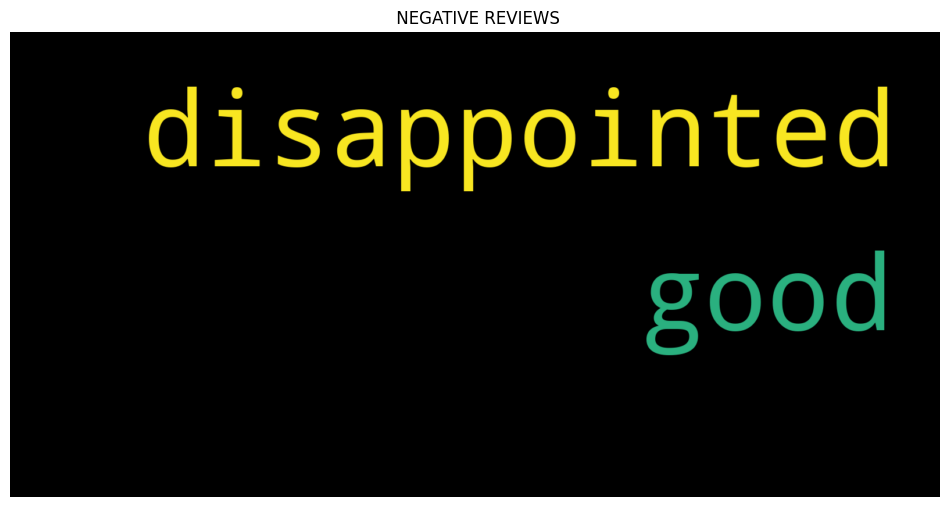

In [ ]:
wordcloud = WordCloud(height=800, width=1600, random_state=21,max_font_size=180).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(' NEGATIVE REVIEWS')
plt.show()

In [ ]:
wordcloud = WordCloud(height=800, width=1600, random_state=21,max_font_size=180).generate(neu_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('NEUTRAL REVIEWS')
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

C:\Users\admin\AppData\Local\Temp\ipykernel_13448\178224859.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_data.corr()


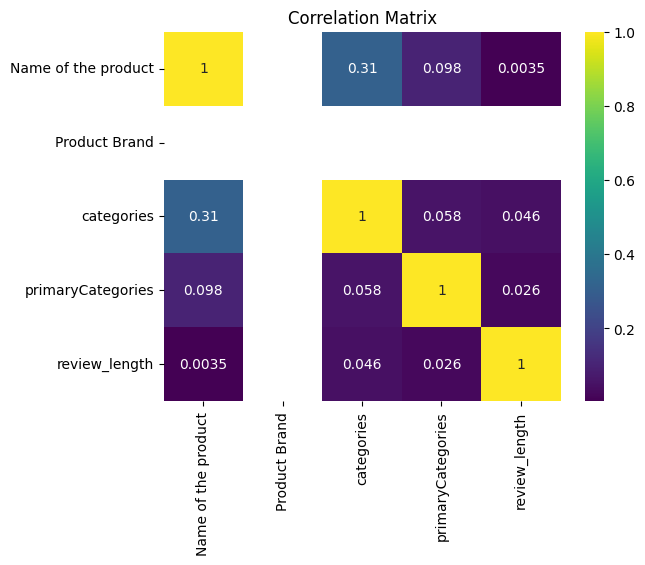

In [ ]:
# Correlation matrix
corr_matrix = train_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

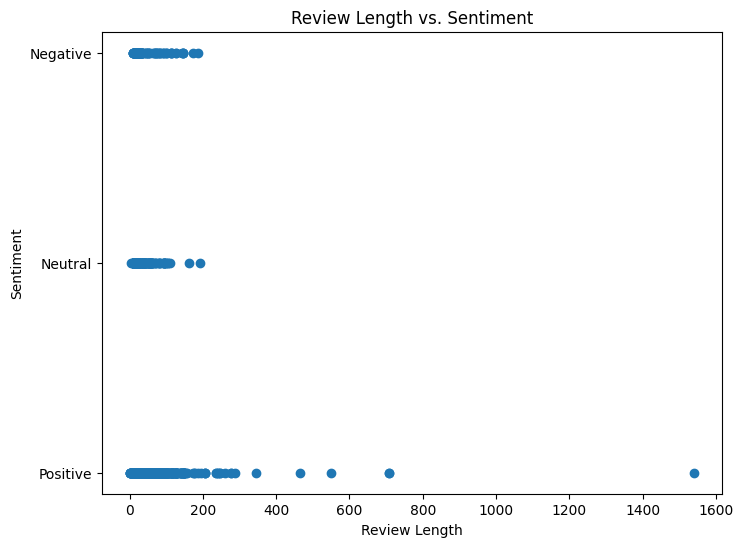

In [ ]:
# Scatter plot of review length vs. sentiment
plt.figure(figsize=(8, 6))
plt.scatter(train_data['review_length'], train_data['sentiment'])
plt.title('Review Length vs. Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Sentiment')
plt.show()


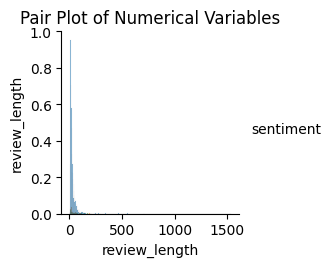

In [ ]:
# Pair plot of selected numerical variables
sns.pairplot(train_data[['review_length', 'sentiment']], hue='sentiment', diag_kind='hist')
plt.title('Pair Plot of Numerical Variables')
plt.show()


In [ ]:
le_senti = LabelEncoder()
train_data['sentiment'] = le_senti.fit_transform(train_data['sentiment'])
hidden_test_data['sentiment'] = le_senti.fit_transform(hidden_test_data['sentiment'])

### Feature enginering

In [ ]:
# Convert list-like text data to strings
train_data['reviews.text'] = train_data['reviews.text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
test_data['reviews.text'] = test_data['reviews.text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
hidden_test_data['reviews.text'] = hidden_test_data['reviews.text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

## TF-IDF Vectorizer

In [ ]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

In [ ]:
# Fit and transform the 'reviews.text' column of train_data
tfidf_train = tfidf_vectorizer.fit_transform(train_data['reviews.text'].astype('str'))
tfidf_test = tfidf_vectorizer.transform(test_data['reviews.text'].astype('str'))
tfidf_hidden_test = tfidf_vectorizer.transform(hidden_test_data['reviews.text'].astype('str'))


In [ ]:
# Convert the TF-IDF matrices to DataFrames for visualization
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_hidden_test_df = pd.DataFrame(tfidf_hidden_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [ ]:
# Print the shape of the resulting DataFrames
print(f"TF-IDF Train Data Shape: {tfidf_train_df.shape}")
print(f"TF-IDF Test Data Shape: {tfidf_test_df.shape}")
print(f"TF-IDF Hidden Test Data Shape: {tfidf_hidden_test_df.shape}")

TF-IDF Train Data Shape: (4000, 1000)
TF-IDF Test Data Shape: (1000, 1000)
TF-IDF Hidden Test Data Shape: (1000, 1000)


In [ ]:
# Save TF-IDF DataFrames to CSV files
tfidf_train_df.to_csv("tfidf_train_df.csv", index=False)
tfidf_test_df.to_csv("tfidf_test_df.csv", index=False)
tfidf_hidden_test_df.to_csv("tfidf_hidden_test_df.csv", index=False)

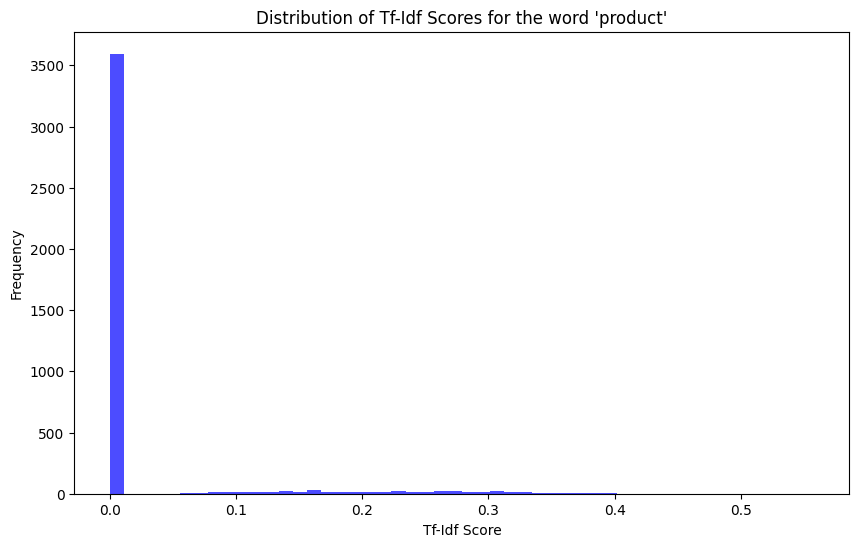

In [ ]:
# Visualize the distribution of Tf-Idf scores for specific words
word = 'product'
tfidf_scores = tfidf_train_df[word]
plt.figure(figsize=(10, 6))
plt.hist(tfidf_scores, bins=50, color='blue', alpha=0.7)
plt.title(f"Distribution of Tf-Idf Scores for the word '{word}'")
plt.xlabel("Tf-Idf Score")
plt.ylabel("Frequency")
plt.show()

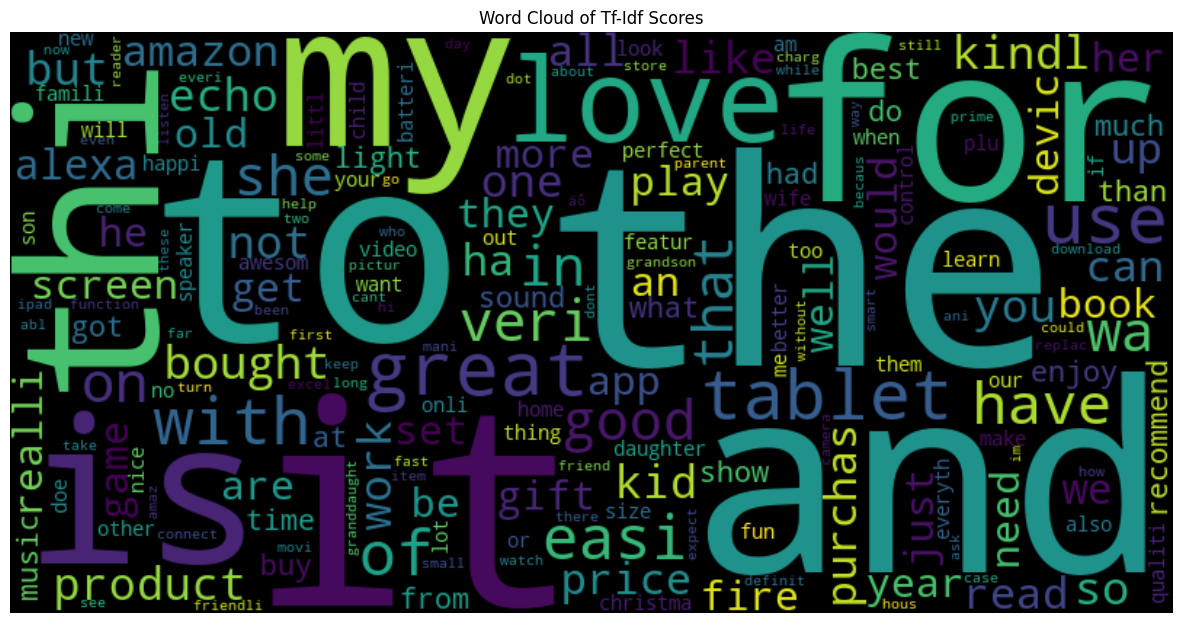

In [ ]:
# Generate and visualize a word cloud based on Tf-Idf scores
tfidf_scores_sum = tfidf_train_df.sum(axis=0)
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(tfidf_scores_sum)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.title("Word Cloud of Tf-Idf Scores")
plt.show()

In [ ]:
# Merge test_data and hidden_test_data
merged_data = pd.concat([test_data, hidden_test_data], ignore_index=True)

# Print the merged dataset for verification
print("Merged Dataset:")
merged_data.head()

Merged Dataset:


,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,19,0,11,0,2016-05-23T00:00:00.000Z,amazon kindl fire lot free app use one want ge...,"[handi, devic]",NaN
1,9,0,6,1,2018-01-02T00:00:00.000Z,echo show great addit amazon famili work like ...,"[anoth, winner, amazon]",NaN
2,2,0,10,0,2017-01-02T00:00:00.000Z,great valu best buy bought christma sale,"[simpl, use, reliabl, far]",NaN
3,13,0,9,0,2017-03-25T00:00:00.000Z,use mine email facebook game go line also load...,[love],NaN
4,9,0,6,1,2017-11-15T00:00:00.000Z,fantast item person bought love,[fantast],NaN


In [ ]:
merged_data.shape

(2000, 8)

In [ ]:
merged_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  2000 non-null   int32 
 1   Product Brand        2000 non-null   int32 
 2   categories           2000 non-null   int32 
 3   primaryCategories    2000 non-null   int32 
 4   reviews.date         2000 non-null   object
 5   reviews.text         2000 non-null   object
 6   reviews.title        2000 non-null   object
 7   sentiment            1000 non-null   object
dtypes: int32(4), object(4)
memory usage: 93.9+ KB


In [ ]:
merged_data.isnull().sum()

Name of the product       0
Product Brand             0
categories                0
primaryCategories         0
reviews.date              0
reviews.text              0
reviews.title             0
sentiment              1000
dtype: int64

In [ ]:
# Define X (features) and y (target)
X = merged_data[['Name of the product', 'Product Brand', 'categories',
                 'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title']]
y = merged_data['sentiment']

In [ ]:
# Impute missing values in y (sentiment)
imputer = SimpleImputer(strategy='most_frequent')
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Update the DataFrame with imputed values
merged_data['sentiment'] = y_imputed

# Verify that missing values have been handled
print("\nAfter handling missing values:")
print(merged_data.isnull().sum())


After handling missing values:
Name of the product    0
Product Brand          0
categories             0
primaryCategories      0
reviews.date           0
reviews.text           0
reviews.title          0
sentiment              0
dtype: int64


In [ ]:
# Create a new column 'combined_text' by concatenating 'reviews.text' and 'reviews.title'
merged_data['combined_text'] = merged_data['reviews.text'].astype(str) + ' ' + merged_data['reviews.title'].astype(str)

In [ ]:
merged_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment', 'combined_text'],
      dtype='object')

In [ ]:
# Define X (features) and y (target)
X = merged_data['combined_text']
y = merged_data['sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Feature extraction: Convert text data to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust the max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [ ]:
# Initialize and train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
# Predictions on the test set
y_pred = nb_classifier.predict(X_test_tfidf)
y_pred

array(['Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positi

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.95


In [ ]:
# Print classification report (precision, recall, F1-score)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         7
     Neutral       0.00      0.00      0.00        11
    Positive       0.95      1.00      0.98       382

    accuracy                           0.95       400
   macro avg       0.32      0.33      0.33       400
weighted avg       0.91      0.95      0.93       400



c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  0   0   7]
 [  0   0  11]
 [  0   0 382]]


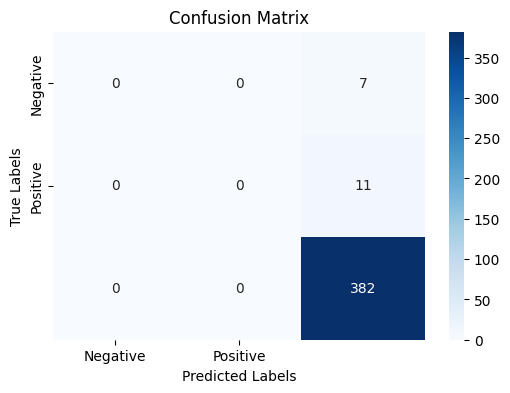

In [ ]:
# Assuming you already have the confusion matrix 'conf_matrix'
class_labels = ['Negative', 'Positive']  # Replace with your actual class labels

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import joblib
# Save the trained model to a file
joblib.dump(nb_classifier, 'multinomial_nb_model.pkl')

['multinomial_nb_model.pkl']

In [ ]:
# Define a function to preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

# Apply the preprocessing function to the 'reviews.text' column
train_data['reviews.text'] = train_data['reviews.text'].apply(preprocess_text)

# Verify preprocessing
train_data['reviews.text'].head()

0    purchas on black fridaypro great price even of...
1    i purchas two amazon in echo plu and two dot p...
2    just an averag alexa option doe show a few thi...
3    veri good product exactli what i want and a ve...
4    thi is the 3rd one ive purchas ive bought one ...
Name: reviews.text, dtype: object

In [ ]:
#  Feature Extraction
# Use CountVectorizer to transform text data into feature vectors
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_data['reviews.text'])

# Labels
y = train_data['sentiment']

# Save the vectorizer for future use
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(3200, 4020) (800, 4020) (3200,) (800,)


### Handling Class Imbalance with SMOTEENN (Combined Oversampling and Undersampling)

In [ ]:
# Initialize SMOTEENN (combination of SMOTE and Edited Nearest Neighbors)
smote_enn = SMOTEENN(random_state=42)

# Apply SMOTEENN to the training data
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Check the shape after resampling
print(X_train_res.shape, y_train_res.shape)

(5744, 4020) (5744,)


In [ ]:
# Initialize the classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_res, y_train_res)

# Save the trained model
joblib.dump(nb_classifier, 'naive_bayes_model.pkl')

['naive_bayes_model.pkl']

In [ ]:
# Make predictions on the validation set
y_val_pred = nb_classifier.predict(X_val)

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.15      0.62      0.24        13
     Neutral       0.09      0.53      0.16        36
    Positive       0.98      0.70      0.82       751

    accuracy                           0.69       800
   macro avg       0.41      0.61      0.40       800
weighted avg       0.93      0.69      0.78       800

Confusion Matrix:
[[  8   5   0]
 [  6  19  11]
 [ 41 184 526]]


In [ ]:
# Apply the same preprocessing function
test_data['reviews.text'] = test_data['reviews.text'].apply(preprocess_text)

# Transform the test data using the saved vectorizer
X_test = vectorizer.transform(test_data['reviews.text'])

# Predict the sentiment using the loaded model
y_test_pred = nb_classifier.predict(X_test)

# Print predictions
print(y_test_pred)

# Evaluate the model if actual sentiments are available in test data
if 'sentiment' in test_data.columns:
    y_test_actual = test_data['sentiment']
    print("Classification Report:")
    print(classification_report(y_test_actual, y_test_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_actual, y_test_pred))
else:
    print("Test data does not contain 'sentiment' column. Predictions have been saved.")

['Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Neutral' 'Positive' 'Positive' 'Neutral' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Neutral' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Neutral' 'Negative' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Negative' 'Neutral'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Negative'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'


In [ ]:
# Save predictions to a CSV file
test_data['predicted_sentiment'] = y_test_pred
test_data.to_csv('test_data_with_predictions.csv', index=False)
print("Predictions saved to 'test_data_with_predictions.csv'")

Predictions saved to 'test_data_with_predictions.csv'


In [ ]:
test_data.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,predicted_sentiment
0,19,0,11,0,2016-05-23T00:00:00.000Z,amazon kindl fire lot free app use one want ge...,"[handi, devic]",Positive
1,9,0,6,1,2018-01-02T00:00:00.000Z,echo show great addit amazon famili work like ...,"[anoth, winner, amazon]",Positive
2,2,0,10,0,2017-01-02T00:00:00.000Z,great valu best buy bought christma sale,"[simpl, use, reliabl, far]",Positive
3,13,0,9,0,2017-03-25T00:00:00.000Z,use mine email facebook game go line also load...,[love],Positive
4,9,0,6,1,2017-11-15T00:00:00.000Z,fantast item person bought love,[fantast],Positive


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  1000 non-null   int32 
 1   Product Brand        1000 non-null   int32 
 2   categories           1000 non-null   int32 
 3   primaryCategories    1000 non-null   int32 
 4   reviews.date         1000 non-null   object
 5   reviews.text         1000 non-null   object
 6   reviews.title        1000 non-null   object
 7   predicted_sentiment  1000 non-null   object
dtypes: int32(4), object(4)
memory usage: 47.0+ KB


In [ ]:
test_data.isnull().sum()

Name of the product    0
Product Brand          0
categories             0
primaryCategories      0
reviews.date           0
reviews.text           0
reviews.title          0
predicted_sentiment    0
dtype: int64

In [ ]:
test_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'predicted_sentiment'],
      dtype='object')

### Tackling Class Imbalance:

In [ ]:
train_data.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_length
0,2,0,10,0,2016-12-26T00:00:00.000Z,purchas on black fridaypro great price even of...,"[power, tablet]",Positive,71
1,5,0,1,1,2018-01-17T00:00:00.000Z,i purchas two amazon in echo plu and two dot p...,"[amazon, echo, plu, awesom]",Positive,113
2,9,0,2,1,2017-12-20T00:00:00.000Z,just an averag alexa option doe show a few thi...,[averag],Neutral,15
3,14,0,22,3,2017-08-04T00:00:00.000Z,veri good product exactli what i want and a ve...,[greattttttt],Positive,12
4,13,0,9,0,2017-01-23T00:00:00.000Z,thi is the 3rd one ive purchas ive bought one ...,"[veri, durabl]",Positive,35


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  4000 non-null   int32 
 1   Product Brand        4000 non-null   int32 
 2   categories           4000 non-null   int32 
 3   primaryCategories    4000 non-null   int32 
 4   reviews.date         4000 non-null   object
 5   reviews.text         4000 non-null   object
 6   reviews.title        4000 non-null   object
 7   sentiment            4000 non-null   object
 8   review_length        4000 non-null   int64 
dtypes: int32(4), int64(1), object(4)
memory usage: 218.9+ KB


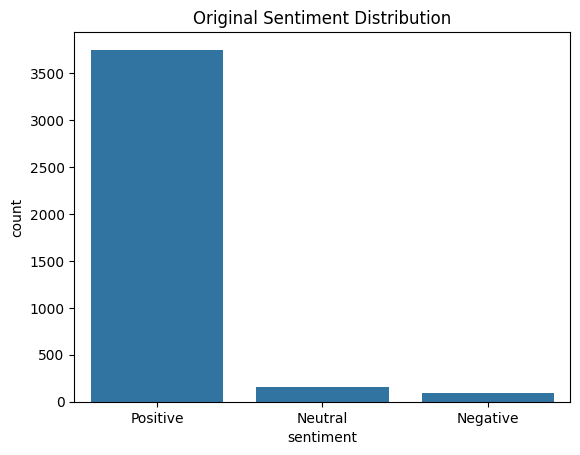

In [ ]:
# Visualize Original Sentiment Distribution
sns.countplot(x='sentiment', data=train_data)
plt.title('Original Sentiment Distribution')
plt.show()

In [ ]:
# Feature and Target Separation
X = train_data['reviews.text']
y = train_data['sentiment']

# Vectorize Text Data Using Tf-Idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [ ]:
# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

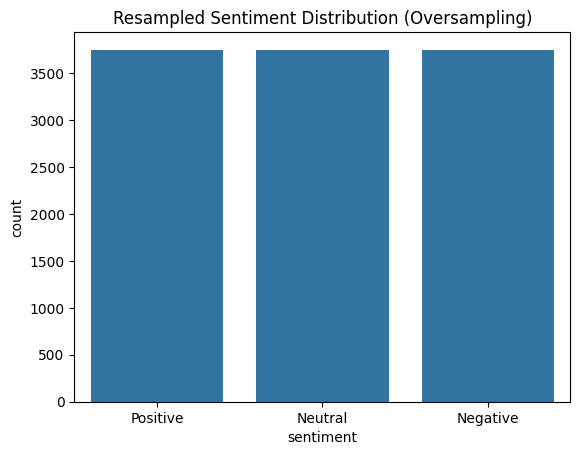

In [ ]:
# Visualize Resampled Sentiment Distribution
sns.countplot(x=y_resampled)
plt.title('Resampled Sentiment Distribution (Oversampling)')
plt.show()


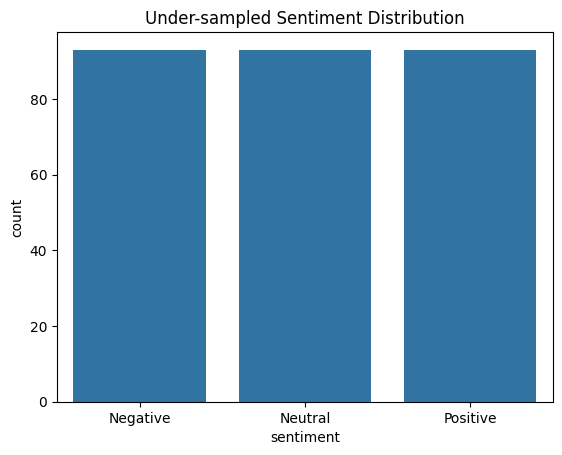

In [ ]:
# Under-sampling Majority Class
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_tfidf, y)

# Visualize Under-sampled Sentiment Distribution
sns.countplot(x=y_under)
plt.title('Under-sampled Sentiment Distribution')
plt.show()

In [ ]:
# Train Classifier with Resampled Data (Oversampling)
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_res, y_train_res)

y_pred_res = nb_classifier.predict(X_val_res)


In [ ]:
print(classification_report(y_val_res, y_pred_res))

              precision    recall  f1-score   support

    Negative       0.96      1.00      0.98       748
     Neutral       0.93      1.00      0.96       733
    Positive       1.00      0.88      0.94       769

    accuracy                           0.96      2250
   macro avg       0.96      0.96      0.96      2250
weighted avg       0.96      0.96      0.96      2250



In [ ]:
print("Confusion Matrix (Oversampling):")
print(confusion_matrix(y_val_res, y_pred_res))

Confusion Matrix (Oversampling):
[[747   0   1]
 [  0 731   2]
 [ 34  56 679]]


In [ ]:
# Calculate Evaluation Metrics
precision = precision_score(y_val_res, y_pred_res, average='weighted')
recall = recall_score(y_val_res, y_pred_res, average='weighted')
f1 = f1_score(y_val_res, y_pred_res, average='weighted')
y_pred_proba_res = nb_classifier.predict_proba(X_val_res)
auc_roc = roc_auc_score(y_val_res, y_pred_proba_res, multi_class='ovr')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC-ROC: {auc_roc}')

Precision: 0.9608428272956954
Recall: 0.9586666666666667
F1-Score: 0.9580532816939892
AUC-ROC: 0.9978266645551966


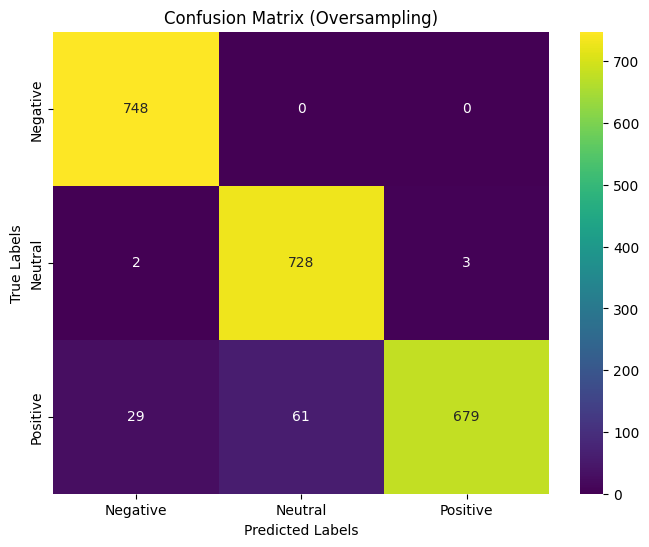

In [ ]:
# Define the confusion matrix
conf_matrix = np.array([[748, 0, 0],
                        [2, 728, 3],
                        [29, 61, 679]])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Oversampling)')
plt.show()

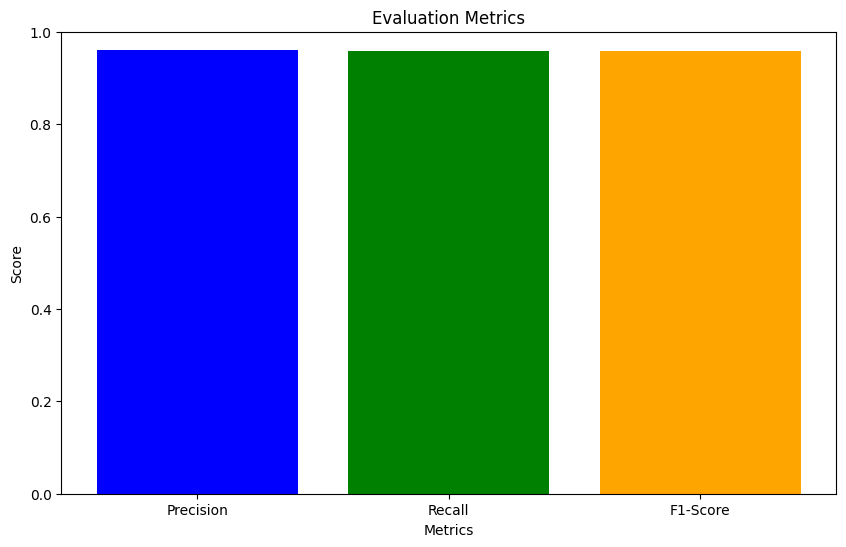

In [ ]:
# Visualize precision, recall, f1-score
metrics = ['Precision', 'Recall', 'F1-Score']
scores = [precision, recall, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color=['blue', 'green', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.ylim(0, 1.0)
plt.show()

In [ ]:
# AUC-ROC requires probability estimates of the positive class
y_pred_proba = nb_classifier.predict_proba(X_val)
auc_roc = roc_auc_score(pd.get_dummies(y_val), y_pred_proba, multi_class='ovr')

In [ ]:
# Save evaluation metrics in a dictionary
evaluation_metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC-ROC': auc_roc
}

# Save evaluation results to a text file
with open('classification_report.txt', 'w') as f:
    f.write('Evaluation Metrics:\n')
    for metric, value in evaluation_metrics.items():
        f.write(f'{metric}: {value:.4f}\n')
    f.write('\nClassification Report:\n')
    f.write(classification_report(y_val_res, y_pred_res))
    f.write('\nConfusion Matrix:\n')
    f.write(str(confusion_matrix(y_val_res, y_pred_res)))

print('Evaluation results saved to classification_report.txt')

Evaluation results saved to classification_report.txt


In [ ]:
train_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_length
0,2,0,10,0,2016-12-26T00:00:00.000Z,purchas on black fridaypro great price even of...,"[power, tablet]",Positive,71
1,5,0,1,1,2018-01-17T00:00:00.000Z,i purchas two amazon in echo plu and two dot p...,"[amazon, echo, plu, awesom]",Positive,113


In [ ]:
test_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,predicted_sentiment
0,19,0,11,0,2016-05-23T00:00:00.000Z,amazon kindl fire lot free app use one want ge...,"[handi, devic]",Positive
1,9,0,6,1,2018-01-02T00:00:00.000Z,echo show great addit amazon famili work like ...,"[anoth, winner, amazon]",Positive


# Model Selection and Advanced Techniques

In [ ]:
# Vectorize text data using Tf-Idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)  # X is your text data

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest (OvR) strategy
svm_classifier.fit(X_train, y_train)
svm_classifier

SVC(kernel='linear')

In [ ]:
# Predictions on validation set
y_pred_svm = svm_classifier.predict(X_val)
y_pred_svm

array(['Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positi

In [ ]:
# Evaluate SVM
accuracy_svm = accuracy_score(y_val, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.4f}')


SVM Accuracy: 0.9463


In [ ]:
# Classification report
print('Classification Report (SVM):')
print(classification_report(y_val, y_pred_svm))

Classification Report (SVM):
              precision    recall  f1-score   support

    Negative       1.00      0.23      0.38        13
     Neutral       1.00      0.08      0.15        36
    Positive       0.95      1.00      0.97       751

    accuracy                           0.95       800
   macro avg       0.98      0.44      0.50       800
weighted avg       0.95      0.95      0.93       800



In [ ]:
# Evaluate SVM
accuracy_svm = accuracy_score(y_val, y_pred_svm)
classification_rep_svm = classification_report(y_val, y_pred_svm)

In [ ]:
# Save to a file
with open('svm_classification_report.txt', 'w') as f:
    f.write(f'SVM Accuracy: {accuracy_svm:.4f}\n')
    f.write('Classification Report (SVM):\n')
    f.write(classification_rep_svm)

print('SVM evaluation results saved to svm_classification_report.txt')

SVM evaluation results saved to svm_classification_report.txt


### Neural Networks (using TensorFlow/Keras)

In [ ]:
# Separate features and target
X = train_data['reviews.text']  # Assuming 'reviews.text' contains the review text
y = train_data['sentiment']  # Assuming 'sentiment' is the target variable

In [ ]:
# Vectorize text data using Tf-Idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [ ]:
from tensorflow.keras.utils import to_categorical
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y_categorical, test_size=0.2, random_state=42)


In [ ]:
# Define neural network model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train.toarray(), y_train, epochs=10, batch_size=32, validation_data=(X_val.toarray(), y_val))

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8885 - loss: 0.5282 - val_accuracy: 0.9388 - val_loss: 0.2272
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9417 - loss: 0.1863 - val_accuracy: 0.9388 - val_loss: 0.2015
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9376 - loss: 0.1461 - val_accuracy: 0.9425 - val_loss: 0.2001
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9400 - loss: 0.1159 - val_accuracy: 0.9488 - val_loss: 0.2193
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9831 - loss: 0.0602 - val_accuracy: 0.9575 - val_loss: 0.2831
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9920 - loss: 0.0251 - val_accuracy: 0.9450 - val_loss: 0.3139
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9976 - loss: 0.0087 - val_accuracy: 0.9500 - val_loss: 0.3484
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9979 - loss: 0.0059 - val_accu

In [ ]:
# Predictions on validation set
y_pred_proba = model.predict(X_val.toarray())
y_pred_nn = np.argmax(y_pred_proba, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
# Convert one-hot encoded y_val back to labels
y_val_labels = np.argmax(y_val, axis=1)

In [ ]:
# Evaluate neural network
accuracy_nn = accuracy_score(y_val_labels, y_pred_nn)
accuracy_nn

0.9425

In [ ]:
classification_rep_nn = classification_report(y_val_labels, y_pred_nn)
print("classification_rep_nn")
print(classification_rep_nn)

classification_rep_nn
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.39      0.36      0.38        36
           2       0.97      0.97      0.97       751

    accuracy                           0.94       800
   macro avg       0.75      0.68      0.71       800
weighted avg       0.94      0.94      0.94       800



In [ ]:
# Save to a file
with open('nn_classification_report.txt', 'w') as f:
    f.write(f'Neural Network Accuracy: {accuracy_nn:.4f}\n')
    f.write('Classification Report (Neural Network):\n')
    f.write(classification_rep_nn)

print('Neural Network evaluation results saved to nn_classification_report.txt')

Neural Network evaluation results saved to nn_classification_report.txt


In [ ]:
# Ensemble Techniques

from sklearn.ensemble import VotingClassifier
import xgboost as xgb

# Separate features and target
X = train_data['reviews.text']  # Assuming 'reviews.text' contains the review text
y = train_data['sentiment']  # Assuming 'sentiment' is the target variable

In [ ]:
# Vectorize text data using Tf-Idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Oversample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [ ]:
# Train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Combine models using VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[
    ('nb', nb_classifier),
    ('xgb', xgb_classifier)
], voting='soft')

# Train the ensemble classifier
ensemble_classifier.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('nb', MultinomialNB()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

In [ ]:
# Predictions on validation set
y_pred_ensemble = ensemble_classifier.predict(X_val)

In [ ]:
# Evaluate ensemble model
accuracy_ensemble = accuracy_score(y_val, y_pred_ensemble)
accuracy_ensemble

0.94875

In [ ]:
classification_rep_ensemble = classification_report(y_val, y_pred_ensemble)
print(classification_rep_ensemble)

              precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       0.53      0.22      0.31        36
           2       0.96      0.99      0.98       751

    accuracy                           0.95       800
   macro avg       0.72      0.61      0.64       800
weighted avg       0.94      0.95      0.94       800



In [ ]:
# Save to a file
with open('ensemble_classification_report.txt', 'w') as f:
    f.write(f'Ensemble Model Accuracy: {accuracy_ensemble:.4f}\n')
    f.write('Classification Report (Ensemble Model):\n')
    f.write(classification_rep_ensemble)

print('Ensemble model evaluation results saved to ensemble_classification_report.txt')

Ensemble model evaluation results saved to ensemble_classification_report.txt


### VADER Sentiment Analyzer

In [ ]:
analyzer = SentimentIntensityAnalyzer()
analyzer

In [ ]:
# Perform Sentiment Analysis and Create Sentiment Score Feature

sentiment_scores = []

for text in train_data['reviews.text']:
    vs = analyzer.polarity_scores(text)
    sentiment_scores.append(vs['compound'])  # Compound score as sentiment score

train_data['sentiment_score'] = sentiment_scores
sentiment_scores

[0.9442,
 0.9274,
 0.0,
 0.7269,
 0.1779,
 0.8481,
 0.9456,
 0.8705,
 0.9001,
 0.0,
 0.765,
 0.7579,
 0.7964,
 0.4215,
 0.0,
 0.8519,
 0.6597,
 0.1265,
 0.4215,
 0.9785,
 0.0,
 0.9246,
 0.1779,
 0.0,
 0.048,
 0.9382,
 0.8519,
 0.4215,
 0.9231,
 -0.1406,
 0.8225,
 0.34,
 0.6249,
 0.6249,
 0.836,
 0.6597,
 0.7906,
 0.7906,
 0.9673,
 0.7783,
 0.839,
 0.7351,
 0.0,
 0.3291,
 0.8608,
 0.6249,
 0.09,
 0.3612,
 0.5994,
 0.9453,
 0.875,
 0.765,
 0.8608,
 0.5574,
 0.9337,
 0.0,
 0.4404,
 -0.34,
 0.0,
 0.7783,
 0.0,
 -0.2023,
 0.7351,
 0.4215,
 0.8126,
 0.5719,
 0.7269,
 0.7003,
 0.7845,
 -0.1027,
 0.7506,
 0.7579,
 0.9403,
 0.3612,
 0.0,
 0.4588,
 0.9849,
 0.6369,
 0.0772,
 0.6369,
 0.8151,
 -0.34,
 0.7174,
 0.0258,
 0.6369,
 0.5659,
 0.3818,
 0.0,
 0.8481,
 0.4939,
 0.7003,
 0.7269,
 0.9349,
 0.8555,
 0.1901,
 -0.4767,
 0.7783,
 0.0693,
 0.765,
 0.9042,
 0.9451,
 0.7964,
 0.765,
 0.8481,
 -0.6377,
 0.8519,
 0.7964,
 0.0,
 0.2737,
 0.6908,
 0.9153,
 0.6486,
 0.8225,
 0.5719,
 0.4588,
 0.5994,
 

In [ ]:
train_data.to_csv('train_data_with_sentiment_scores.csv', index=False)

In [ ]:
# Normalize sentiment scores to range [0, 1] (if sentiment scores are not in this range)
min_score = min(train_data['sentiment_score'])
max_score = max(train_data['sentiment_score'])
train_data['normalized_sentiment_score'] = (train_data['sentiment_score'] - min_score) / (max_score - min_score)

In [ ]:
# Split data into X and y
X = train_data[['reviews.text', 'normalized_sentiment_score']]
y = train_data['sentiment']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Vectorize text data using Tf-Idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X['reviews.text'])

In [ ]:
# Combine Tf-Idf vectors with normalized sentiment score
X_combined = np.hstack((X_tfidf.toarray(), X['normalized_sentiment_score'].values.reshape(-1, 1)))
X_combined

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.97141652],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.96255669],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.47347326],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.64154625],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.73394157],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.47347326]])

#### Naive Bayes Classifier


In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [ ]:
# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Predictions and Evaluation
y_pred_nb = nb_classifier.predict(X_val)


In [ ]:
# Print accuracy and other evaluation metrics as needed
accuracy_nb = accuracy_score(y_val, y_pred_nb)
print(f'Naive Bayes Accuracy: {accuracy_nb:.4f}')

Naive Bayes Accuracy: 0.9387


In [ ]:
# Classification Report and Confusion Matrix
print('Classification Report (Naive Bayes):')
print(classification_report(y_val, y_pred_nb))

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        13
     Neutral       0.00      0.00      0.00        36
    Positive       0.94      1.00      0.97       751

    accuracy                           0.94       800
   macro avg       0.31      0.33      0.32       800
weighted avg       0.88      0.94      0.91       800



c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
print('Confusion Matrix (Naive Bayes):')
print(confusion_matrix(y_val, y_pred_nb))

Confusion Matrix (Naive Bayes):
[[  0   0  13]
 [  0   0  36]
 [  0   0 751]]


In [ ]:
# Save results to a file
with open('naive_bayes_sentiment_analysis.txt', 'w') as f:
    f.write(f'Naive Bayes Accuracy: {accuracy_nb:.4f}\n\n')
    f.write('Classification Report (Naive Bayes):\n')
    f.write(classification_report(y_val, y_pred_nb))
    f.write('\n\nConfusion Matrix (Naive Bayes):\n')
    f.write(str(confusion_matrix(y_val, y_pred_nb)))

print('Results saved to naive_bayes_sentiment_analysis.txt')

Results saved to naive_bayes_sentiment_analysis.txt


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### LSTM Implementation for Sentiment Analysis

In [ ]:
# LSTM Implementation for Sentiment Analysis

# Separate features and target
X = train_data['reviews.text']
y = train_data['sentiment']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
label_encoder

LabelEncoder()

In [ ]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [ ]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [ ]:
# Pad sequences to ensure uniform length
max_length = 100  # Adjust as needed based on your data
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

##### Build LSTM Model

In [ ]:
embedding_dim = 100
max_length = 100  # Define the maximum sequence length

model = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim),  # Input_dim should match the size of your tokenizer
    SpatialDropout1D(0.2),
    LSTM(units=100, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the LSTM Model

epochs = 10  # Adjust as needed
batch_size = 64

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
early_stopping

In [ ]:
from keras.callbacks import ModelCheckpoint

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_lstm_model.keras', save_best_only=True)
checkpoint

In [ ]:
# Train the model
history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val_pad, y_val), callbacks=[early_stopping, checkpoint])
history

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.8559 - loss: 0.5057 - val_accuracy: 0.9388 - val_loss: 0.2686
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.9376 - loss: 0.2707 - val_accuracy: 0.9388 - val_loss: 0.2683
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9416 - loss: 0.2557 - val_accuracy: 0.9413 - val_loss: 0.2682
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.9446 - loss: 0.2513 - val_accuracy: 0.9413 - val_loss: 0.2644
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9368 - loss: 0.2764 - val_accuracy: 0.9413 - val_loss: 0.2674
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9313 - loss: 0.2946 - val_accuracy: 0.9413 - val_loss: 0.2695
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9348 - loss: 0.2830 - val_accuracy: 0.9413 - val_loss: 0.2615
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9404 - loss: 0.2640 - val_accuracy:

In [ ]:
# Evaluate the LSTM Model

from keras.models import load_model

# Load the best model
best_model = load_model('best_lstm_model.keras')
best_model


<Sequential name=sequential_1, built=True>

In [ ]:
# Predict probabilities for each class
y_pred_prob = best_model.predict(X_val_pad)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [ ]:
# Convert probabilities to class labels
y_pred_lstm = np.argmax(y_pred_prob, axis=1)

In [ ]:
# Print evaluation metrics
print('Classification Report (LSTM):')
print(classification_report(y_val, y_pred_lstm))

Classification Report (LSTM):
              precision    recall  f1-score   support

           0       1.00      0.15      0.27        13
           1       0.00      0.00      0.00        36
           2       0.94      1.00      0.97       751

    accuracy                           0.94       800
   macro avg       0.65      0.38      0.41       800
weighted avg       0.90      0.94      0.91       800



c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
print('Confusion Matrix (LSTM):')
print(confusion_matrix(y_val, y_pred_lstm))

Confusion Matrix (LSTM):
[[  2   0  11]
 [  0   0  36]
 [  0   0 751]]


In [ ]:
# Save evaluation metrics to a file
with open('lstm_classification_report.txt', 'w') as f:
    f.write('Classification Report (LSTM):\n')
    f.write(classification_report(y_val, y_pred_lstm) + '\n\n')
    f.write('Confusion Matrix (LSTM):\n')
    f.write(np.array2string(conf_matrix) + '\n')

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

###  compare the performance of neural network models with traditional machine learning algorithms,

In [ ]:
# Check the structure of the data
train_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_length,sentiment_score,normalized_sentiment_score
0,2,0,10,0,2016-12-26T00:00:00.000Z,purchas on black fridaypro great price even of...,"[power, tablet]",Positive,71,0.9442,0.971417
1,5,0,1,1,2018-01-17T00:00:00.000Z,i purchas two amazon in echo plu and two dot p...,"[amazon, echo, plu, awesom]",Positive,113,0.9274,0.962557


In [ ]:
hidden_test_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,19,0,11,0,2016-05-23T00:00:00.000Z,amazon kindl fire ha a lot of free app and can...,"[veri, handi, devic]",Positive
1,9,0,6,1,2018-01-02T00:00:00.000Z,the echo show is a great addit to the amazon f...,"[anoth, winner, from, amazon]",Positive


In [ ]:
test_data.head(2)

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,predicted_sentiment
0,19,0,11,0,2016-05-23T00:00:00.000Z,amazon kindl fire lot free app use one want ge...,"[handi, devic]",Positive
1,9,0,6,1,2018-01-02T00:00:00.000Z,echo show great addit amazon famili work like ...,"[anoth, winner, amazon]",Positive


In [ ]:
# Parameters
max_words = 10000
max_length = 100
embedding_dim = 100

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['reviews.text'])
tokenizer

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(train_data['reviews.text'])
X_val_seq = tokenizer.texts_to_sequences(hidden_test_data['reviews.text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['reviews.text'])


In [ ]:
# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['sentiment'])
y_val = label_encoder.transform(hidden_test_data['sentiment'])
y_test = label_encoder.transform(test_data['predicted_sentiment'])

In [ ]:
# Convert labels to categorical for neural network models
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

## Train and Evaluate Traditional Machine Learning Models

In [ ]:
# Initialize SVM model with linear kernel
svm_model = SVC(kernel='linear', probability=True)

# Train the SVM model (considering only a subset of data for faster execution)
subset_size = 100  # Example: use a subset of 1000 samples
svm_model.fit(X_train_pad[:subset_size], y_train[:subset_size])

SVC(kernel='linear', probability=True)

In [ ]:
# Predictions on test set
y_pred_svm = svm_model.predict(X_test_pad)

In [ ]:
# Evaluate performance
print('SVM Accuracy:', svm_model.score(X_test_pad, y_test))
print('Classification Report (SVM):')
print(classification_report(y_test, y_pred_svm))
print('Confusion Matrix (SVM):')
print(confusion_matrix(y_test, y_pred_svm))

SVM Accuracy: 0.822
Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.02      0.04      0.03        28
           1       0.05      0.01      0.02        90
           2       0.88      0.93      0.90       882

    accuracy                           0.82      1000
   macro avg       0.32      0.33      0.32      1000
weighted avg       0.78      0.82      0.80      1000

Confusion Matrix (SVM):
[[  1   0  27]
 [  5   1  84]
 [ 41  21 820]]


In [ ]:
# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_pad, y_train)
y_pred_nb = nb_model.predict(X_test_pad)

In [ ]:
print('Naive Bayes Accuracy:', accuracy_score(y_test, y_pred_nb))
print('Classification Report (NB):')
classification_rep_nb = classification_report(y_test, y_pred_nb)
print(classification_rep_nb)

print('Confusion Matrix (NB):')
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print(conf_matrix_nb)

Naive Bayes Accuracy: 0.85
Classification Report (NB):
              precision    recall  f1-score   support

           0       0.07      0.04      0.05        28
           1       0.00      0.00      0.00        90
           2       0.88      0.96      0.92       882

    accuracy                           0.85      1000
   macro avg       0.32      0.33      0.32      1000
weighted avg       0.78      0.85      0.81      1000

Confusion Matrix (NB):
[[  1   0  27]
 [  0   0  90]
 [ 14  19 849]]


### Train and Evaluate Neural Network Models

In [ ]:
def create_lstm_model(max_words, embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
hidden_test_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')

In [ ]:
test_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'predicted_sentiment'],
      dtype='object')

In [ ]:
train_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment', 'review_length', 'sentiment_score',
       'normalized_sentiment_score'],
      dtype='object')

In [ ]:
merged_data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment', 'combined_text'],
      dtype='object')